In [2]:
%pip install numpy pandas matplotlib statsmodels


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Interactive widget
from ipywidgets import interact


# Retina mode
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
file_path = 'co2_mm_mlo.csv'
names = 'year,month,decimal date,average,deseasonalized,ndays,sdev,unc'.split(',')

# no index
df = pd.read_csv(file_path, skiprows=41, names=names, index_col=False)
print(df.head())

   year  month  decimal date  average  deseasonalized  ndays  sdev   unc
0  1958      3     1958.2027   315.70          314.43     -1 -9.99 -0.99
1  1958      4     1958.2877   317.45          315.16     -1 -9.99 -0.99
2  1958      5     1958.3699   317.51          314.71     -1 -9.99 -0.99
3  1958      6     1958.4548   317.24          315.14     -1 -9.99 -0.99
4  1958      7     1958.5370   315.86          315.18     -1 -9.99 -0.99


In [3]:
df.index = pd.to_datetime(df[['year', 'month']].apply(lambda x: '{}-{}'.format(x[0], x[1]), axis=1))

In [4]:
# Create X and y

# X = months since first measurement
# print(len(df))
X = np.array(range(len(df)))
y = df.average.values

In [5]:
# Spliting the data into train and test, 80:20 split
split_index = int(0.8 * len(y))

train_data = y[:split_index]
X_train_data = X[:split_index]
test_data = y[split_index:]
X_test_data = X[split_index:]

Text(0, 0.5, 'CO2 Level')

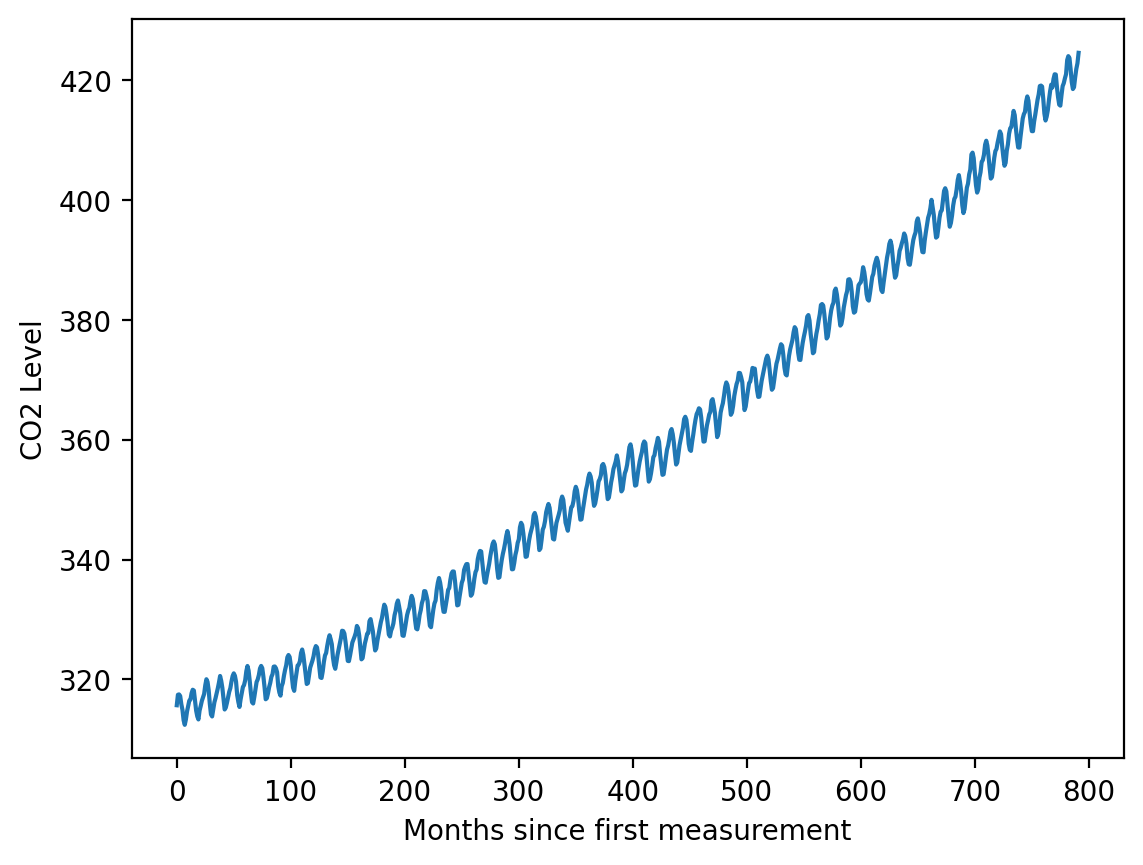

In [6]:
plt.plot(X, y)
plt.xlabel('Months since first measurement')
plt.ylabel('CO2 Level')

MLP

Test RMSE: 35.00826494925417


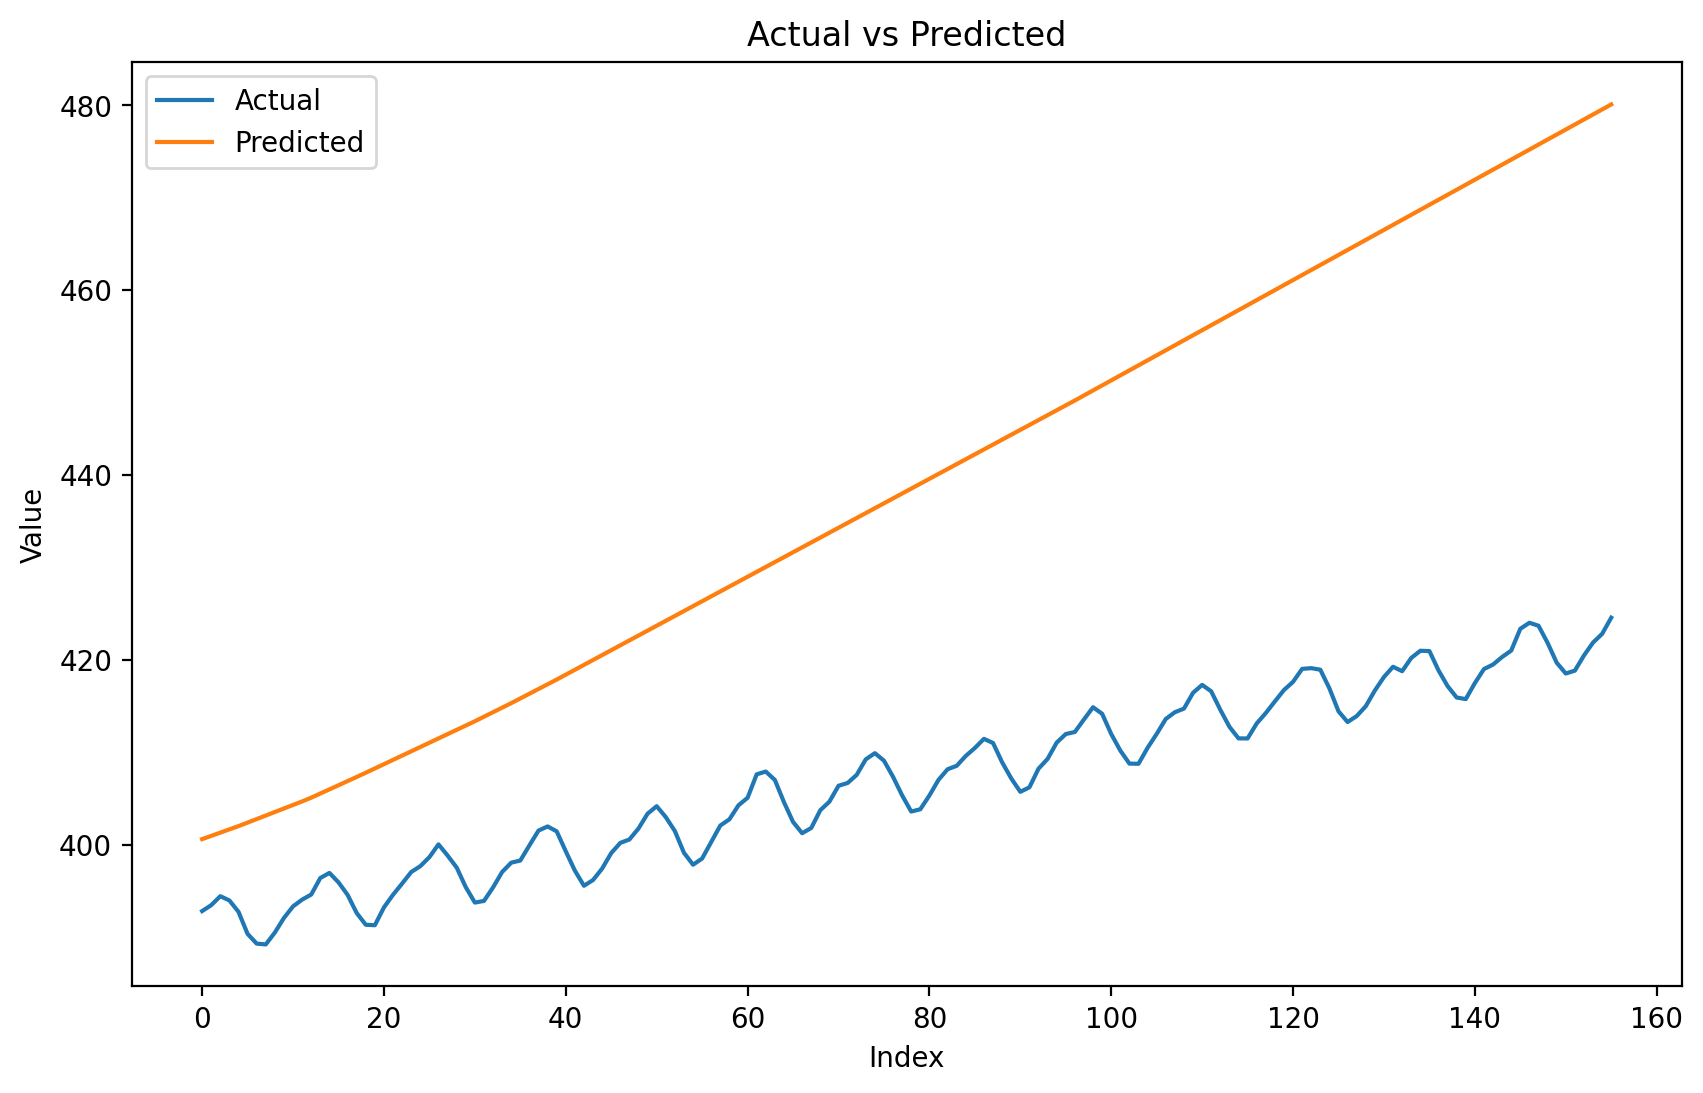

In [7]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming you have already loaded the data and split it into train and test sets
# Let's assume train_data, test_data, X_train_data, and X_test_data are defined elsewhere

# Parameters
K = 3  # Number of previous readings to consider
T = 1  # Number of future readings to predict

# Function to prepare input-output pairs
def prepare_data(data, X_data, k, t):
    X = []
    y = []
    for i in range(len(data) - k - t + 1):
        X.append(X_data[i:i+k])
        y.append(data[i+k:i+k+t])
    return np.array(X), np.array(y)

# Prepare training data
X_train, y_train = prepare_data(train_data, X_train_data, K, T)

# Prepare testing data
X_test, y_test = prepare_data(test_data, X_test_data, K, T)

# Initialize MLP regressor
mlp_regressor = MLPRegressor(hidden_layer_sizes=(50, 50), activation='relu', random_state=1, max_iter=1000)

# Train the MLP model
mlp_regressor.fit(X_train, y_train.ravel())  # ravel() flattens y_train to ensure it's a 1D array

# Predictions
test_predictions = mlp_regressor.predict(X_test)

# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print("Test RMSE:", test_rmse)
# Plotting the predictions against actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()



Moving Average

Root Mean Squared Error (MSE) for Moving Average: 2.275745294915293


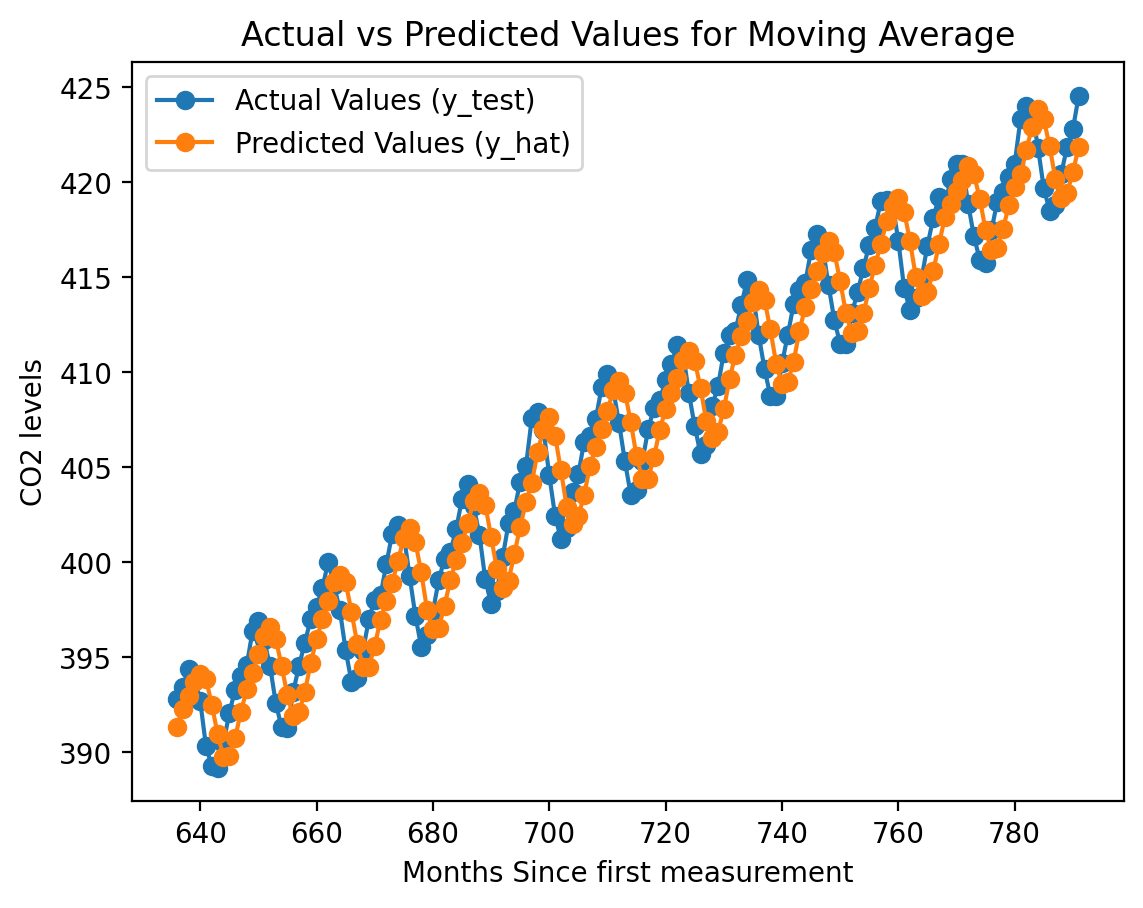

In [8]:
def make_dataset_ma(y, X, lag):
    X_train = []
    y_train = []
    months = []
    for i in range(len(y)-lag):
        row = y[i:i+lag]
        y_train.append(y[i+lag])
        X_train.append(pd.Series(row).mean())  # Calculate moving average
        month_value = X[i+lag]
        months.append(month_value)

    X_train = pd.Series(X_train)
    y_train = pd.Series(y_train)
    return X_train, y_train, months


lag = 3 #As we increase the lag the error reduces
X_train_ma, y_train_ma, months_train_ma = make_dataset_ma(train_data, X_train_data, lag)
reg_ma = LinearRegression().fit(X_train_ma.values.reshape(-1, 1), y_train_ma)
X_test_ma, y_test_ma, months_test_ma = make_dataset_ma(test_data, X_test_data, lag)
y_hat_ma = reg_ma.predict(X_test_ma.values.reshape(-1, 1))
rmse_ma =np.sqrt(mean_squared_error(y_test_ma, y_hat_ma))

print(f"Root Mean Squared Error (MSE) for Moving Average: {rmse_ma}")
# Plotting the predicted output for lag=10 for the test sequence
plt.plot(months_test_ma, y_test_ma, label='Actual Values (y_test)', marker='o')
plt.plot(months_test_ma, y_hat_ma, label='Predicted Values (y_hat)', marker='o')
plt.xlabel('Months Since first measurement')
plt.ylabel('CO2 levels')
plt.title('Actual vs Predicted Values for Moving Average')
plt.legend()
plt.show()


ARMA

c:\Users\madha\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Root Mean Squared Error (MSE) for ARMA(6,1): 6.45237816323343


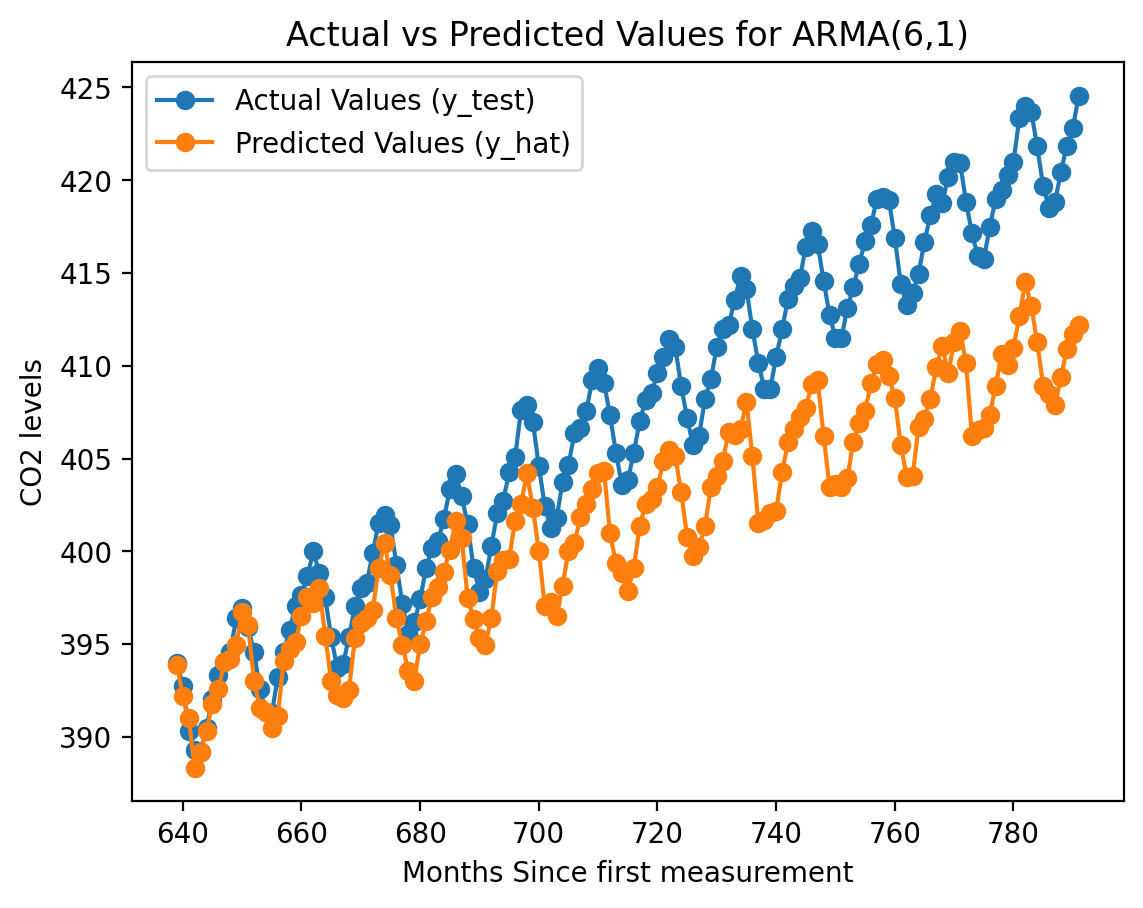

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Define a function to create dataset for ARMA model
def make_dataset_arma(y, X, p, q):
    X_train = []
    y_train = []
    months_train = []

    for i in range(max(p, q), len(y)):
        y_train.append(y[i])
        X_train.append(y[i-p:i] + X[i-q:i])  # Combine AR and MA terms
        months_train.append(X[i])

    return np.array(X_train), np.array(y_train), np.array(months_train)
# p_values = range(1, 8)  # AR order
# q_values = range(1, 3)  # MA order

# # Placeholder for storing RMSEs and parameter combinations
# results = []

# for p in p_values:
#     for q in q_values:
#         try:
#             # Prepare training and testing datasets
#             X_train_arma, y_train_arma, months_train_arma = make_dataset_arma(train_data, X_train_data, p, q)
#             X_test_arma, y_test_arma, months_test_arma = make_dataset_arma(test_data, X_test_data, p, q)
            
#             # Fit the ARMA model
#             model_arma = ARIMA(y_train_arma, order=(p, 0, q), exog=X_train_arma)
#             result_arma = model_arma.fit()
            
#             # Forecast
#             y_hat_arma = result_arma.forecast(steps=len(X_test_arma), exog=X_test_arma)
            
#             # Calculate RMSE
#             rmse_arma = np.sqrt(mean_squared_error(y_test_arma, y_hat_arma))
            
#             # Store results
#             results.append((p, q, rmse_arma))
#         except Exception as e:
#             print(f"Failed to fit ARMA({p},{q}) due to: {str(e)}")

# # Identify the parameters that yield the minimum RMSE
# min_rmse_result = min(results, key=lambda x: x[2])

# min_rmse_result, results
# # Example run of the model using ARMA(2, 1)
p = 6  # AR order
q = 1  # MA order

X_train_arma, y_train_arma, months_train_arma = make_dataset_arma(train_data, X_train_data, p, q)
X_test_arma, y_test_arma, months_test_arma = make_dataset_arma(test_data, X_test_data, p, q)

# Fit the ARMA model
model_arma = ARIMA(y_train_arma, order=(p, 0, q), exog=X_train_arma)
result_arma = model_arma.fit()

# Forecast
y_hat_arma = result_arma.forecast(steps=len(X_test_arma), exog=X_test_arma)

# Calculate Mean Squared Error (MSE)
rmse_arma = np.sqrt(np.mean((y_test_arma - y_hat_arma)**2))
print(f"Root Mean Squared Error (RMSE) for ARMA({p},{q}): {rmse_arma}")

# Plotting the predicted output for ARMA model
plt.plot(months_test_arma, y_test_arma, label='Actual Values (y_test)', marker='o')
plt.plot(months_test_arma, y_hat_arma, label='Predicted Values (y_hat)', marker='o')
plt.xlabel('Months Since first measurement')
plt.ylabel('CO2 levels')
plt.title(f'Actual vs Predicted Values for ARMA({p},{q})')
plt.legend()
plt.show()


MLP

In [10]:
def make_dataset(y, X, lag):
    X_train = []
    y_train = []
    months_train = []

    for i in range(len(y)-lag):
        row = y[i:i+lag]
        y_train.append(y[i+lag])
        X_train.append(row)

        month_value = X[i+lag]  # Assuming X contains month values
        months_train.append(month_value)

    X_train = pd.DataFrame(X_train)
    y_train = pd.Series(y_train)
    months_train = pd.Series(months_train)

    return X_train, y_train, months_train


Epoch [10/200], Loss: 7343.42626953125
Epoch [20/200], Loss: 1250.8978271484375
Epoch [30/200], Loss: 1181.7618408203125
Epoch [40/200], Loss: 114.82366180419922
Epoch [50/200], Loss: 181.38229370117188
Epoch [60/200], Loss: 24.977291107177734
Epoch [70/200], Loss: 24.075464248657227
Epoch [80/200], Loss: 13.756962776184082
Epoch [90/200], Loss: 7.985363960266113
Epoch [100/200], Loss: 8.80982494354248
Epoch [110/200], Loss: 7.611425876617432
Epoch [120/200], Loss: 7.6063408851623535
Epoch [130/200], Loss: 7.594524383544922
Epoch [140/200], Loss: 7.54138708114624
Epoch [150/200], Loss: 7.5407938957214355
Epoch [160/200], Loss: 7.54075288772583
Epoch [170/200], Loss: 7.538293838500977
Epoch [180/200], Loss: 7.53759765625
Epoch [190/200], Loss: 7.537363529205322
Epoch [200/200], Loss: 7.537001609802246
Root Mean Squared Error (RMSE): 2.98119927475114


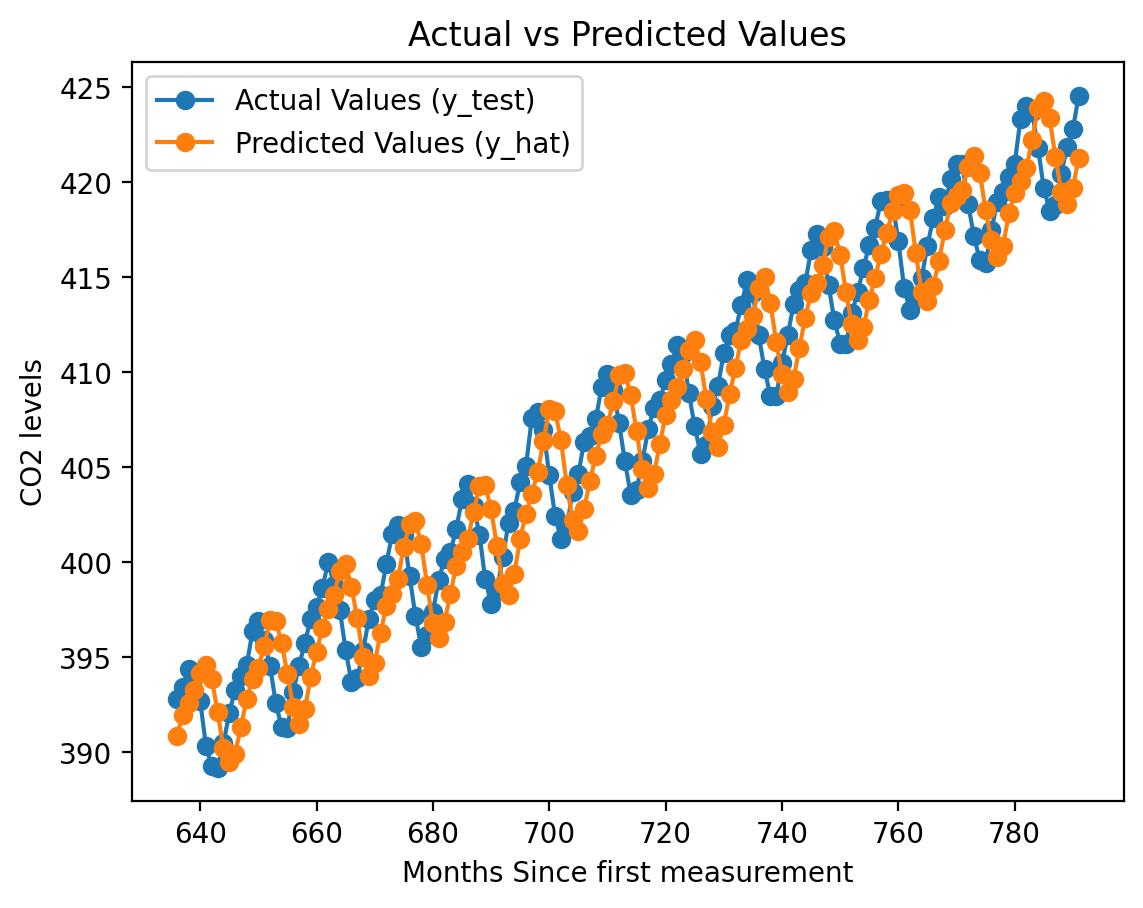

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Convert data to PyTorch tensors
def prepare_data(X, y):
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32)
    return X_tensor, y_tensor

# Train the MLP model
def train_model(model, X_train, y_train, num_epochs=100, learning_rate=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Make predictions using the trained model
def predict(model, X_test):
    with torch.no_grad():
        return model(X_test).numpy()

# Example run of the MLP model
lag = 3
input_size = lag
hidden_size = 3 # You can adjust this according to your problem
output_size = 1

# Prepare data
X_train, y_train, _ = make_dataset(train_data, X_train_data, lag)
X_test, y_test, months_test = make_dataset(test_data, X_test_data, lag)
X_train_tensor, y_train_tensor = prepare_data(X_train, y_train)
X_test_tensor, y_test_tensor = prepare_data(X_test, y_test)

# Initialize and train the model
model = MLP(input_size, hidden_size, output_size)
train_model(model, X_train_tensor, y_train_tensor, num_epochs=200, learning_rate=0.01)

# Make predictions
y_hat = predict(model, X_test_tensor)

# Calculate MSE
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
print(f"Root Mean Squared Error (RMSE): {rmse}")


# Plotting the predicted output for the test sequence
plt.plot(months_test, y_test, label='Actual Values (y_test)', marker='o')
plt.plot(months_test, y_hat, label='Predicted Values (y_hat)', marker='o')
plt.xlabel('Months Since first measurement')
plt.ylabel('CO2 levels')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()
